In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib widget

import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
import csv
from skimage.measure import marching_cubes
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from os.path import split,join,splitext

import pandas as pd
from scipy.stats import multivariate_normal
import os

In [2]:
ontology_name = '/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'

### Load UPenn ontology + Generate lists of descendents

In [3]:
xS,S,_,_ = emlddmm.read_data(seg_name)

In [4]:
# Transforms xS into a set of coordinates
XS = np.stack(np.meshgrid(*xS,indexing='ij'),-1)

In [5]:
# Center of mass of region 2294 (Definition of the 1st moment of the indicator function for label 2294)
# np.sum(XS*(S[0,...,None]==2294))/np.sum(S==2294)

In [6]:
parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1


['\ufeffid', 'name', 'acronym', 'red', 'green', 'blue', 'structure_order', 'parent_id', 'parent_acronym']


In [7]:
# we need to find all the descendants of a given label
# first we'll get children
children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

In [8]:
# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

In [9]:
descendents_and_self = dict(descendents)
for o in ontology:
    if o not in descendents_and_self:
        descendents_and_self[o] = [o]
    else:
        descendents_and_self[o].append(o)

In [10]:
ontology

{0: ('background', 'background', -1),
 997: ('root', 'root', -1),
 8: ('grey', 'Basic cell groups and regions', 997),
 567: ('CH', 'Cerebrum', 8),
 688: ('CTX', 'Cerebral cortex', 567),
 695: ('CTXpl', 'Cortical plate', 688),
 315: ('Isocortex', 'Isocortex', 695),
 184: ('FrA', 'Frontal association cortex', 315),
 68: ('FrA-1', 'Frontal pole, layer 1', 184),
 667: ('FrA-2/3', 'Frontal pole, layer 2/3', 184),
 2325: ('FrA-5', 'Frontal pole, layer 5', 184),
 500: ('M', 'motor cortex', 315),
 985: ('M1', 'Primary motor cortex', 500),
 320: ('M1-1', 'Primary motor cortex, layer 1', 985),
 943: ('M1-2/3', 'Primary motor cortex, layer 2/3', 985),
 648: ('M1-5', 'Primary motor cortex, layer 5', 985),
 844: ('M1-6a', 'Primary motor cortex, layer 6a', 985),
 882: ('M1-6b', 'Primary motor cortex, layer 6b', 985),
 2017: ('FrC3', 'Frontal cortex, area 3', 985),
 2334: ('FrC3-1', 'Frontal cortex, area 3, layer1', 2017),
 2335: ('FrC3-2/3', 'Frontal cortex, area 3, layer2/3', 2017),
 2336: ('FrC3-5

## Generate Boolean masks for CP, CPr (+CPre), CPi, CPc (+CPce)

In [11]:
# find all the descendents of Caudoputemen- rostral
# and caudoputemen rostral- extreme

In [12]:
# these are all the structures in the CP
cp = list(descendents_and_self[672])
Scp = np.zeros_like(S)
for l in cp:
    Scp = np.logical_or(Scp,S==l)

In [13]:
# these are the structures one level below CP, with extreme's merged in
rostral = list(descendents_and_self[2376]) # rostral extreme
rostral.extend(list(descendents_and_self[2491])) # rostral 
rostral = list(dict.fromkeys(rostral))

intermediate = list(descendents_and_self[2492]) # intermediate

caudal = list(descendents_and_self[2496]) # caudal
caudal_ = list(descendents_and_self[2495]) # caudal extreme
caudal.extend(caudal_)

In [14]:
Srostral = np.zeros_like(S)
for l in rostral:
    Srostral = np.logical_or(Srostral, S==l)

In [15]:
Sintermediate = np.zeros_like(S)
for l in intermediate:
    Sintermediate = np.logical_or(Sintermediate, S==l)

In [16]:
Scaudal = np.zeros_like(S)
for l in caudal:
    Scaudal = np.logical_or(Scaudal, S==l)

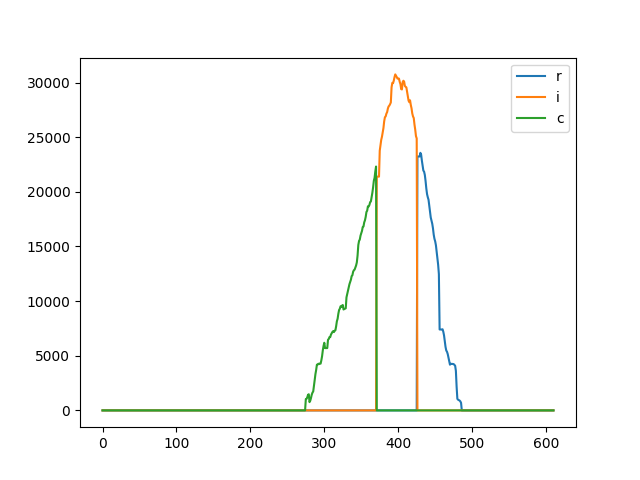

In [17]:
fig,ax = plt.subplots()
ax.plot(np.sum(Srostral>0,axis=(0,2,3)),label='r')
ax.plot(np.sum(Sintermediate>0,axis=(0,2,3)),label='i')
ax.plot(np.sum(Scaudal>0,axis=(0,2,3)),label='c')
ax.legend()

In [18]:
# TODO
# add one more level down the tree

def generate_region_mask(S, regionID):
    self_and_children = list(descendents_and_self[regionID])
    region_mask = np.zeros_like(S)
    for i in self_and_children:
        region_mask = np.logical_or(region_mask, S==i)
    return region_mask

# === Striatum Dorsal Region (STRd) ===

# CP regions
Scpr_m   = generate_region_mask(S,2294)
Scpr_imd = generate_region_mask(S,2295)
Scpr_imv = generate_region_mask(S,2296)
Scpr_l   = generate_region_mask(S,2497)
Scpi_dm  = generate_region_mask(S,2498)
Scpi_vm  = generate_region_mask(S,2500)
Scpi_dl  = generate_region_mask(S,2499)
Scpi_vl  = generate_region_mask(S,2501)
Scpc_d   = generate_region_mask(S,2493)
Scpc_i   = generate_region_mask(S,2494)
Scpc_v   = generate_region_mask(S,2490)

# Non-CP regions
# S_lss = generate_region_mask(S,2001) # Lateral strip of the striatum (Outdated)
S_ast = generate_region_mask(S,2050) # Amygdalostriatial transition

# === Striatum Ventral Region (STRv) ===
S_acb  = generate_region_mask(S,56)  # Accumbens nucleus
S_ipac = generate_region_mask(S,998) # Interstitial nucleus of the posterior limb of the anterior commissure
S_tu   = generate_region_mask(S,754) # Olfactory tubercle

# === (10/3/23) Striatum adjacent regions ===
S_lsx = generate_region_mask(S,275)  # Lateral septal complex
S_samy = generate_region_mask(S,278) # Striatum-like amygdalar nuclei
S_pal = generate_region_mask(S,803)  # Pallidum

# === (10/4/23) Striatum adjacent regions ===
S_cl =   generate_region_mask(S,583) # Claustrum
S_en =   generate_region_mask(S,942) # Endopiriform nucleus
S_pir =  generate_region_mask(S,961) # Piriform nucleus

In [19]:
print(f'N (Scp): {np.sum(Scp):,}')
print(f'N (Scpr): {np.sum(Srostral):,}')
print(f'N (Scpi): {np.sum(Sintermediate):,}')
print(f'N (Scpc): {np.sum(Scaudal):,}')

print(f'N (Scpr_m): {np.sum(Scpr_m):,}')
print(f'N (Scpr_imd): {np.sum(Scpr_imd):,}')
print(f'N (Scpr_imv): {np.sum(Scpr_imv):,}')
print(f'N (Scpr_l): {np.sum(Scpr_l):,}')

print(f'N (Scpi_dm): {np.sum(Scpi_dm):,}')
print(f'N (Scpi_vm): {np.sum(Scpi_vm):,}')
print(f'N (Scpi_dl): {np.sum(Scpi_dl):,}')
print(f'N (Scpi_vl): {np.sum(Scpi_vl):,}')

print(f'N (Scpc_d): {np.sum(Scpc_d):,}')
print(f'N (Scpc_i): {np.sum(Scpc_i):,}')
print(f'N (Scpc_v): {np.sum(Scpc_v):,}')

print(f'N (S_ast): {np.sum(S_ast):,}')

print(f'N (S_acb): {np.sum(S_acb):,}')
print(f'N (S_ipac): {np.sum(S_ipac):,}')
print(f'N (S_tu): {np.sum(S_tu):,}')

print(f'N (S_lsx): {np.sum(S_lsx):,}')
print(f'N (S_samy): {np.sum(S_samy):,}')
print(f'N (S_pal): {np.sum(S_pal):,}')

print(f'N (S_cl): {np.sum(S_cl):,}')
print(f'N (S_en): {np.sum(S_en):,}')
print(f'N (S_pir): {np.sum(S_pir):,}')

N (Scp): 3,229,761
N (Scpr): 706,051
N (Scpi): 1,520,835
N (Scpc): 958,160
N (Scpr_m): 70,819
N (Scpr_imd): 99,533
N (Scpr_imv): 111,221
N (Scpr_l): 291,109
N (Scpi_dm): 421,650
N (Scpi_vm): 225,215
N (Scpi_dl): 255,682
N (Scpi_vl): 618,288
N (Scpc_d): 256,855
N (Scpc_i): 425,212
N (Scpc_v): 197,721
N (S_ast): 32,769
N (S_acb): 602,895
N (S_ipac): 127,466
N (S_tu): 565,446
N (S_lsx): 546,346
N (S_samy): 428,806
N (S_pal): 1,235,621
N (S_cl): 100,992
N (S_en): 432,277
N (S_pir): 1,653,666


In [20]:
# I think what I'd like to do is assign a gaussian to each region
# then give the neurons a distribution based on the Gaussian
# to do this I should load a set of neurons
# and also start visualizing

# what I think would make sense is to take all the cp structures
# blur them a lot
# then assign probabilities
# we also want to look at the neurons though

In [21]:
# i want to start by visualizing
# we need to load swc files
# and we need to contour the surfaces
d = [x[1] - x[0] for x in xS]


In [22]:
down = 16
xSd,Scpd = emlddmm.downmode(xS,Scp[0],down=[down,down,down])

/home/dtward/data/csh_data/emlddmm/emlddmm.py:642: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  S_ = mode(S_,axis=0)[0][0]


In [23]:
dd = [x[1] - x[0] for x in xSd]

In [24]:
verts,faces,normals,values = marching_cubes(Scpd,level=0.5,spacing=dd)
verts = verts + np.array([x[0] for x in xSd])

## Load SWC files and Display 2x2 figure

In [25]:
# swcdir = '../swc_out_v08' # this is tme07
# swcdir = '../dragonfly_tme09-1/swc_out_v08'
# swcdir = '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs'

brain = 'TME08-1'
swcdir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs'
files = glob(join(swcdir,'*.swc'))
files = [f for f in files if 'permuted' not in f]
files

['/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/126_TME08-1_30x_Str_03B_x10703_y19209_z262_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/196_TME08-1_30x_Str_05A_x4192_y8886_z266_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/070_TME08-1_30x_Str_03A_x10604_y9246_z388_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/089_TME08-1_30x_Str_03A_x13329_y15236_z146_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/124_TME08-1_30x_Str_03B_x10385_y16980_z320_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/177_TME08-1_30x_Str_04B_x2128_y17866_z324_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/115_TME08-1_30x_Str_03A_x904

In [26]:
x = []
for file in files:
    with open(file)  as f:
        for i,line in enumerate(f):    
            print(line)
            if 'Tward' in line:                
                continue
            else:
                if ',' in line:
                    lim = ','
                else:
                    lim = ''
                coords = [float(c) for c in line.split(lim)[2:5]]                
                    
                x.append(coords)
                break
    
            
x = np.array(x)            
            

1,2300,1328.0889892578125,2608.678466796875,-680.62841796875,1.0,-1

1,2488,495.3385314941406,-3338.443115234375,356.34027099609375,1.0,-1

1,2480,1477.179931640625,-1645.1002197265625,1376.7991943359375,1.0,-1

1,2298,1579.8460693359375,-984.1388549804688,129.13670349121094,1.0,-1

1,2301,1281.9105224609375,2552.017333984375,-229.89537048339844,1.0,-1

1,2298,1144.537109375,-1370.9609375,-284.64617919921875,1.0,-1

1,2370,1297.4906005859375,-1872.260986328125,173.1656036376953,1.0,-1

1,2374,1187.6600341796875,1920.769287109375,-330.65057373046875,1.0,-1

1,2395,2094.85302734375,2063.670654296875,175.0404815673828,1.0,-1

1,2301,1097.849609375,-2654.733154296875,-519.853515625,1.0,-1

1,2481,1488.9447021484375,2671.3388671875,1694.0078125,1.0,-1

1,551,395.98638916015625,-2699.689453125,1395.7049560546875,1.0,-1

1,2300,1767.120849609375,-2061.90478515625,-580.3322143554688,1.0,-1

1,2380,991.870361328125,1603.720458984375,-1317.2366943359375,1.0,-1

1,2050,-614.72607421875,-3283.2338

### Generate + Save figure

Text(0.5, 0.98, 'TME08-1')

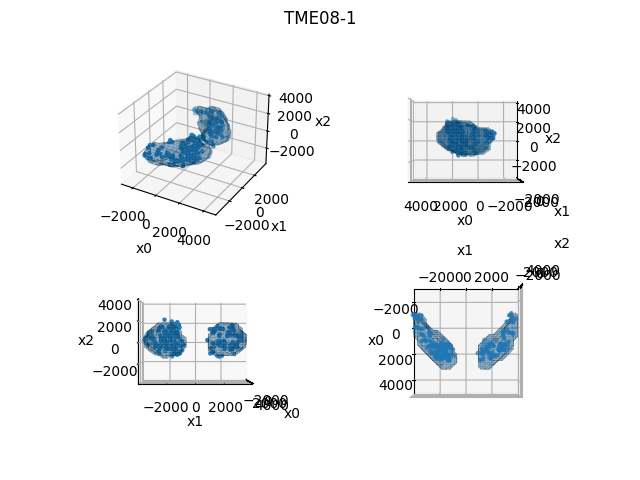

In [27]:
s = 5
alpha = 0.25
lw = 0.25


mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)


ax = fig.add_subplot(2,2,2,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(0,90)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)



ax = fig.add_subplot(2,2,3,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(0,0)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)



ax = fig.add_subplot(2,2,4,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(90,0)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)

# fig.suptitle(swcdir.split('/')[-2])
# fig.savefig('CP_SWC_QC_figure_'+swcdir.split('/')[-2]+'.jpg')

fig.suptitle(f'{brain}')
# fig.savefig(join(f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/',f'CP_SWC_QC_figure_{brain}.jpg'))

In [28]:
# raise Exception(f'End of QC figure generation for {brain}')

In [29]:
# so what is a plan going forward
# I'd like to take every blob as a gaussian
# the height is its volume
# the mean is its mean
# the covariance is its covariance
# the only trouble here is the left right issue
# another posiblility is to just blur the labels
# this may get rid of small structures though
# but I could give less blur to the small structures

In [30]:
# first going forward
# 1. make a figure like this to get a sense of the uncertainty for each brain
# 2. make a probabilitistic version of the CP structures.
# I'd like to model each structure as a gaussian blob (ellispoids with soft boundaries)
# this needs three parameters
# the mean (a 3 element vector)
# the covariance (3x3 symmetric matrix)
# and the height/amplitude of the gaussian (one positive number)

# The height (amplitude) should be the number of voxels in the structure
# the mean, is going to be the first moment of the segmentation
# the covariance, is the second central moment of the segmentation.

### Compute + Save Gaussian parameters for CP

In [31]:
def generate_gaussian_param(subregion_mask, hemi, fname):
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere
    
    # ===== Compute Gaussian parameters =====
    
    # number of voxels in 'subregion'
    Ncp = np.sum(subregion_mask*LR_indicator)
    # print(f'number of voxels {Ncp}')
    
    # note xS tells us the location of each voxel
    # let's compute the first moment
    mucp = [np.sum(xS[0][:,None,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[1][:,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[2][:]*subregion_mask*LR_indicator)/Ncp]
    # print(f'mu {mucp}')
    
    # now calculate the covariance matrix
    covcp01 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[1][:,None] - mucp[1])*subregion_mask*LR_indicator)/Ncp # here row 0 column 1
    covcp02 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 0 column 2
    covcp12 = np.sum((xS[1][None,:,None] - mucp[1])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 1 column 2
    
    covcp00 = np.sum(((xS[0][:,None,None] - mucp[0])**2)*subregion_mask*LR_indicator)/Ncp # here row 0 column 0
    covcp11 = np.sum(((xS[1][None,:,None] - mucp[1])**2)*subregion_mask*LR_indicator)/Ncp # here row 1 column 1
    covcp22 = np.sum(((xS[2][None,None,:] - mucp[2])**2)*subregion_mask*LR_indicator)/Ncp # here row 2 column 2
    
    covcp = [[covcp00,covcp01,covcp02],[covcp01,covcp11,covcp12],[covcp02,covcp12,covcp22]]
    
    # print('cov:')
    # print(f'{covcp[0]}')
    # print(f'{covcp[1]}')
    # print(f'{covcp[2]}')
    
    # Save Gaussian parameters in.npz file with keys [height, mu, cov]
    save_path = join('/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
    np.savez(save_path,height=[Ncp],mu=mucp,cov=covcp)
    print(f'Saved {fname}\n')

genParam = False
if genParam:
    for hemi in ['L','R']:
        generate_gaussian_param(Scp, hemi,f'cp_param_{hemi}.npz')
        generate_gaussian_param(Srostral, hemi,f'cpr_param_{hemi}.npz')
        generate_gaussian_param(Sintermediate, hemi,f'cpi_param_{hemi}.npz')
        generate_gaussian_param(Scaudal, hemi,f'cpc_param_{hemi}.npz')
        
        generate_gaussian_param(Scpr_m, hemi,f'cpr_m_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imd, hemi,f'cpr_imd_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imv, hemi,f'cpr_imv_param_{hemi}.npz')
        generate_gaussian_param(Scpr_l, hemi,f'cpr_l_param_{hemi}.npz')
        
        generate_gaussian_param(Scpi_dm, hemi,f'cpi_dm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vm, hemi,f'cpi_vm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_dl, hemi,f'cpi_dl_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vl, hemi,f'cpi_vl_param_{hemi}.npz')
        
        generate_gaussian_param(Scpc_d, hemi,f'cpc_d_param_{hemi}.npz')
        generate_gaussian_param(Scpc_i, hemi,f'cpc_i_param_{hemi}.npz')
        generate_gaussian_param(Scpc_v, hemi,f'cpc_v_param_{hemi}.npz')

        generate_gaussian_param(S_ast, hemi, f'ast_param_{hemi}.npz')
        
        generate_gaussian_param(S_acb, hemi, f'acb_param_{hemi}.npz')
        generate_gaussian_param(S_ipac, hemi, f'ipac_param_{hemi}.npz')
        generate_gaussian_param(S_tu, hemi, f'tu_param_{hemi}.npz')
        
        generate_gaussian_param(S_lsx, hemi, f'lsx_param_{hemi}.npz')
        generate_gaussian_param(S_samy, hemi, f'samy_param_{hemi}.npz')
        generate_gaussian_param(S_pal, hemi, f'pal_param_{hemi}.npz')
        
        generate_gaussian_param(S_cl, hemi,f'cl_param_{hemi}.npz')
        generate_gaussian_param(S_en, hemi,f'en_param_{hemi}.npz')
        generate_gaussian_param(S_pir, hemi,f'pir_param_{hemi}.npz')

### Load Gaussian parameters given hemi and subregion

In [32]:
# hemi = 'L'
hemi = 'R'
subregion = ''

fname = f'cpc_v_param_{hemi}.npz'
fpath = join(f'/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
out = np.load(fpath)

h = out['height'][0]
mu = out['mu']
cov = out['cov']

print(f'Displating parameters for {fname};\n')
print(f'height: {h}')
print(f'mu: {mu}')
print(f'cov: {cov}')

Displating parameters for cpc_v_param_R.npz;

height: 98845
mu: [ 394.72375942 3143.2739137  1075.84389701]
cov: [[123992.11677122 -29055.38829264  19248.51805967]
 [-29055.38829264  79812.81631632 -31988.42170582]
 [ 19248.51805967 -31988.42170582  75230.84760312]]


In [33]:
# once we have parameters for each gaussian
# then we can evalute them at every point in space
# so for a given cell body, we can find a distribution over this number of regions
# for each level of the tree, you can get a distribution over all the structures in that level
# start with R-I-C level
# TODO, come up with some measure of concordance
#   that is related to nick's labels, but allows some slop

In [34]:
# we don't really believe the uncertaint is given by the voxel size (we're not getting 1 voxel accurate registration)
# we believe it is related to the anatomy

### Compute distance transform for each mask

In [35]:
from scipy.ndimage import distance_transform_edt
import time

def generateDistanceTransform(xS, mask, hemi, fname, save_path = '', scale_factor = 10):
    start = time.time()
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere

    if save_path == '':
        save_path = '/home/abenneck/dragonfly_work/distance_parameters/'

    transformedMask = np.exp(-distance_transform_edt(1-mask*LR_indicator)/scale_factor)
    # transformedMask[transformedMask == 1.0] = 0.0
    transformedMask = transformedMask / np.sum(transformedMask)
    
    # Save distance transform parameters in .npz file with keys [mask]
    save_path = join(save_path,fname)
    np.savez(save_path, mask = transformedMask.astype(np.float32))
    print(f'Saved {fname} after {time.time() - start : .2f} s')
    
    return transformedMask

saveDistanceParam = False
if saveDistanceParam:
    for hemi in ['L','R']:
        generateDistanceTransform(xS, Scp, hemi, f'cp_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Srostral, hemi, f'cpr_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Sintermediate, hemi, f'cpi_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scaudal, hemi, f'cpc_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpr_m, hemi, f'cpr_m_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imd, hemi, f'cpr_imd_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imv, hemi, f'cpr_imv_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_l, hemi, f'cpr_l_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpi_dm, hemi, f'cpi_dm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vm, hemi, f'cpi_vm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_dl, hemi, f'cpi_dl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vl, hemi, f'cpi_vl_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpc_d, hemi, f'cpc_d_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_i, hemi, f'cpc_i_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_v, hemi, f'cpc_v_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_ast, hemi, f'ast_dist_param_{hemi}.npz')
        
        generateDistanceTransform(xS, S_acb, hemi, f'acb_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_ipac, hemi, f'ipac_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_tu, hemi, f'tu_dist_param_{hemi}.npz')
        
        generateDistanceTransform(xS, S_lsx, hemi, f'lsx_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_samy, hemi, f'samy_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_pal, hemi, f'pal_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_cl, hemi, f'cl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_en, hemi, f'en_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_pir, hemi, f'pir_dist_param_{hemi}.npz')

### Load dist param

In [36]:
out = np.load('/home/abenneck/dragonfly_work/distance_parameters/cp_dist_param_L.npz')
out = out['mask']

x, y, z = 100, 100, -100

print(out[0, x, y, z])

6.3741224e-15


### Preprocessing helper functions

In [37]:
def L1_filter_gauss(fileName):
    if len(fileName) <= 15 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def L2_filter_gauss(fileName):
    if len(fileName) > 15 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def non_CP_filter_gauss(fileName):
    if not L2_filter_gauss(fileName) and not L1_filter_gauss(fileName) and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def L1_filter_dist(fileName):
    if len(fileName) <= 21 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def L2_filter_dist(fileName):
    if len(fileName) > 21 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def non_CP_filter_dist(fileName):
    if not L2_filter_dist(fileName) and not L1_filter_dist(fileName) and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def get_coord_list(region_id, XS, S):
    self_and_children = list(descendents_and_self[region_id])
    allCoords = list()
    for idNum in self_and_children:
        regionCoords = XS[S[0]==idNum]
        if len(regionCoords) != 0:
            for coord in regionCoords:
                allCoords.append(coord)
    return allCoords

### Probability computation helper functions

In [49]:
# Distance with vectorization
def dist_from_cp(allCoords, soma_location, useForLoop = False):
    if useForLoop:
        minDist = -1
        for c in allCoords:
            distance = math.dist(c,soma_location)
            if minDist == -1 or minDist > distance:
                minDist = distance
        return minDist        
    else:
        # out = allCoords-soma_location => [allCoords[0]-soma_location, allCoords[1]-soma_location, ...]
        # out = (out)**2                => Square all terms within out
        # out = np.sum(out, axis=1)     => [out[0][0]+out[0][1]+out[0][2], out[1][0]+out[1][1]+out[1][2], ...]
        # out = np.sqrt(out)            => sqrt all terms within out
        # out = np.min(out)             => min of all distances
        return np.min(np.sqrt(np.sum((allCoords-soma_location)**2, axis=1)))

# Round neuron coord to nearest atlas coord
def roundCoord(sub_xS, coord):
    if coord < np.min(sub_xS):
        coord = np.min(sub_xS)
    elif coord > np.max(sub_xS):
        coord = np.max(sub_xS)
    else:
        coord_rounded = 20*round(coord/20) # Round coordinate to nearest 20
        if coord < 0:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
        else:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
    return coord

def append_nonCP_regions(allProb):

    nonCP_regions = ['ACB','AST','CL','EN','IPAC','LSX','PAL','PIR','SAMY','TU']
    for l in range(3):
        if l == 0:
            last_CP_col = 'CP_R'
        elif l == 1:
            last_CP_col = 'CPr_R'
        else: # l == 2
            last_CP_col = 'CPr_m_R'

        for i,region in enumerate(nonCP_regions):
            if i == 0:
                prevCol = last_CP_col
            else:
                prevCol = f'{nonCP_regions[i-1]}{l}_R'

            allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
            allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])




    

    # # Append to L0
    # allProb.insert(allProb.columns.get_loc('CP_R')+1,'ACB0_L',allProb['ACB_L'])
    # allProb.insert(allProb.columns.get_loc('ACB0_L')+1,'ACB0_R',allProb['ACB_R'])

    # # Append to L1
    # allProb.insert(allProb.columns.get_loc('CPr_R')+1,'ACB1_L',allProb['ACB_L'])
    # allProb.insert(allProb.columns.get_loc('ACB1_L')+1,'ACB1_R',allProb['ACB_R'])
    
    # # Append to L2
    # allProb.insert(allProb.columns.get_loc('CPr_m_R')+1,'ACB2_L',allProb['ACB_L'])
    # allProb.insert(allProb.columns.get_loc('ACB2_L')+1,'ACB2_R',allProb['ACB_R'])
    
    return allProb    

# Absolute probabilities => (Normalize probabilities at multiple levels) => Conditional probabilities
def normalize_prob(allProb):    
    L0_labels = ['CP_L','CP_R','ACB0_L','ACB0_R','AST0_L','AST0_R','CL0_L','CL0_R','EN0_L','EN0_R','IPAC0_L','IPAC0_R','LSX0_L','LSX0_R','PAL0_L','PAL0_R','PIR0_L','PIR0_R','SAMY0_L','SAMY0_R','TU0_L','TU0_R']
    allProb[L0_labels] = allProb[L0_labels].div(np.sum(allProb[L0_labels], axis=1), axis=0)

    L1_labels = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R','ACB1_L','ACB1_R','AST1_L','AST1_R','CL1_L','CL1_R','EN1_L','EN1_R','IPAC1_L','IPAC1_R','LSX1_L','LSX1_R','PAL1_L','PAL1_R','PIR1_L','PIR1_R','SAMY1_L','SAMY1_R','TU1_L','TU1_R']
    allProb[L1_labels] = allProb[L1_labels].div(np.sum(allProb[L1_labels], axis=1), axis=0)
    
    L2_labels = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R','ACB2_L','ACB2_R','AST2_L','AST2_R','CL2_L','CL2_R','EN2_L','EN2_R','IPAC2_L','IPAC2_R','LSX2_L','LSX2_R','PAL2_L','PAL2_R','PIR2_L','PIR2_R','SAMY2_L','SAMY2_R','TU2_L','TU2_R']
    allProb[L2_labels] = allProb[L2_labels].div(np.sum(allProb[L2_labels], axis=1), axis=0)

    nonCP_labels = ['ACB_L','ACB_R','AST_L','AST_R','CL_L','CL_R','EN_L','EN_R','IPAC_L','IPAC_R','LSX_L','LSX_R','PAL_L','PAL_R','PIR_L','PIR_R','SAMY_L','SAMY_R','TU_L','TU_R']
    allProb[nonCP_labels] = allProb[nonCP_labels].div(np.sum(allProb[nonCP_labels], axis=1), axis=0)

    return allProb

### Postprocessing helper functions

In [39]:
# Filter to remove the .ipynb_checkpoints file from lists
def brain_filter(dirName):
    if dirName == '.ipynb_checkpoints' or dirName == 'TME20-1':
        return False
    else:
        return True

# Return a pd.DataFrame (1 x len (df)) of the column name in df containing the corresponding value in vals for each row of df
def xlookup(vals, df, cName = ''):
    out = list()
    for row in df.iterrows():
        idx, row = row
        val = vals[idx]
        colName = row[row == val].keys()[0]
        out.append(colName)
    return pd.DataFrame(data=out, columns = [cName])

# Return a pd.Series (1 x len(df)) of the nth largest value in each row of df
def nmax(df, n):
    out = list()
    for row in df.iterrows():
        idx, row = row
        nth_largest = sorted(row, reverse=True)[n-1]
        out.append(nth_largest)
    return pd.Series(data=out)

def compute_top_n_maximums(data, all_labels, n=3):
    
    for i, labels in enumerate(all_labels):
        L0_df = data[labels]
        
        L0_P1 = L0_df.max(axis=1)
        L0_1 = xlookup(L0_P1, L0_df)
    
        if i == 0:
            leftmost_col_name = 'fname'
        else:
            leftmost_col_name = f'P(L{i-1},3)'
        
        data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
        data.insert(data.columns.get_loc(f'L{i} (1)')+1,f'P(L{i},1)',L0_P1)
        
        L0_P2 = nmax(L0_df, 2)
        L0_2 = xlookup(L0_P2, L0_df)
        data.insert(data.columns.get_loc(f'P(L{i},1)')+1,f'L{i} (2)',L0_2)
        data.insert(data.columns.get_loc(f'L{i} (2)')+1,f'P(L{i},2)',L0_P2)
        
        L0_P3 = nmax(L0_df,3)
        L0_3 = xlookup(L0_P3, L0_df)
        data.insert(data.columns.get_loc(f'P(L{i},2)')+1,f'L{i} (3)',L0_3)
        data.insert(data.columns.get_loc(f'L{i} (3)')+1,f'P(L{i},3)',L0_P3)

    return data

## Generate probability distributions, assign labels to neurons, and save csv files locally

In [53]:
# brains = sorted(filter(brain_filter, os.listdir('/home/abenneck/dragonfly_work/dragonfly_outputs/')))
brains = ['TME07-1', 'TME08-1', 'TME09-1', 'TME10-1', 'TME10-3', 'TME12-1']
# brains = ['TME08-1']

# allRegionCoords = get_coord_list(672, XS, S) # 672 is regionID for CP
# allRegionCoords = np.asarray(allRegionCoords)
# uniform_prior = 1/100

# print('Loading regional amplitudes')
# start = time.time()
# # Create list of priors from presaved parameters
# paramDir = '/home/abenneck/dragonfly_work/gaussian_parameters'
# L1_files = sorted(filter(L1_filter_gauss,os.listdir(paramDir)))
# L2_files = sorted(filter(L2_filter_gauss,os.listdir(paramDir)))
# nonCP_files = sorted(filter(non_CP_filter_gauss,os.listdir(paramDir)))
# allPriors = list()
# for fileList in [L1_files, L2_files, nonCP_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         norm_factor = data['height'].item()
#         allPriors.append(norm_factor)
# print(f'Finished loading amp in {time.time() - start} s\n')

# print('Loading distance transform distributions')
# start = time.time()
# # Create list of distributions from presaved distance transforms
# paramDir = '/home/abenneck/dragonfly_work/distance_parameters'
# L1_files = sorted(filter(L1_filter_dist,os.listdir(paramDir)))
# L2_files = sorted(filter(L2_filter_dist,os.listdir(paramDir)))
# nonCP_files = sorted(filter(non_CP_filter_dist,os.listdir(paramDir)))
# allTransforms = list()
# for fileList in [L1_files, L2_files, nonCP_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         probDist = data['mask']
#         allTransforms.append(probDist)
#         print(file)
# print(f'Finished loading distributions in {time.time() - start} s\n')

# if True:
#     raise Exception('Rewrite some of the below code')

print('Generating probabilities')
start = time.time()
# Generate probabilities
for brain in brains:
    # Define relevant directories
    neuronDir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs/'

    # Note: The ACB#_x columns are inserted after computing absolute probabilities, but before normalization
    L0_col = ['mouse ID', 'slice', 'hemi', 'neuron ID','dist (CP)','fname','CP_L','CP_R']
    L1_col = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R',]
    L2_col = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R']
    nonCP_col = ['ACB_L','ACB_R','AST_L','AST_R','CL_L','CL_R','EN_L','EN_R','IPAC_L','IPAC_R','LSX_L','LSX_R','PAL_L','PAL_R','PIR_L','PIR_R','SAMY_L','SAMY_R','TU_L','TU_R']
    allCol = np.concatenate([L0_col, L1_col, L2_col, nonCP_col])
    allProb = pd.DataFrame(columns=allCol)
    
    # Generate regional probabilities for every neuron in neuronDir
    row_idx = 0
    for i, file in enumerate(sorted(os.listdir(neuronDir))):
        if "mapped.swc" in file:
            # Load soma coordinates
            data = pd.read_csv(os.path.join(neuronDir,file))
            x = float(data.columns[2])
            y = float(data.columns[3])
            z = float(data.columns[4])
            soma_location = [x,y,z]

            # Get idx for soma location in xS
            x_ind = np.where(xS[0] == roundCoord(xS[0], x))[0].item()
            y_ind = np.where(xS[1] == roundCoord(xS[1], y))[0].item() 
            z_ind = np.where(xS[2] == roundCoord(xS[2], z))[0].item()

            # Get metadata from filename
            mouseID = file.split('_')[1]
            sliceID = file.split('_')[4][:-1]
            hemiID = file.split('_')[4][-1]
            neuronID = file.split('_')[0]
    
            # Compute probabilities from distance transform probabilities
            cpDist = dist_from_cp(allRegionCoords,soma_location)
            neuronProb = [mouseID, sliceID, hemiID, neuronID, cpDist, file]
            for j, prior in enumerate(allPriors):
                neuronProb.append(uniform_prior*allTransforms[j][0, x_ind, y_ind, z_ind])

            allProb.loc[row_idx] = neuronProb
            row_idx+=1
            print(f'{i}/{len(sorted(os.listdir(neuronDir)))} Finished {file}\n')

    # Insert Non-CP regions at each level
    allProb = append_nonCP_regions(allProb)

    # Normalize probabilities at each level
    allProb = normalize_prob(allProb)

    # Identify top 3 regions for each neuron and insert columns into allProb
    L0_labels = ['CP_L','CP_R','ACB0_L','ACB0_R','AST0_L','AST0_R','CL0_L','CL0_R','EN0_L','EN0_R','IPAC0_L','IPAC0_R','LSX0_L','LSX0_R','PAL0_L','PAL0_R','PIR0_L','PIR0_R','SAMY0_L','SAMY0_R','TU0_L','TU0_R']
    L1_labels = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R','ACB1_L','ACB1_R','AST1_L','AST1_R','CL1_L','CL1_R','EN1_L','EN1_R','IPAC1_L','IPAC1_R','LSX1_L','LSX1_R','PAL1_L','PAL1_R','PIR1_L','PIR1_R','SAMY1_L','SAMY1_R','TU1_L','TU1_R']
    L2_labels = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R','ACB2_L','ACB2_R','AST2_L','AST2_R','CL2_L','CL2_R','EN2_L','EN2_R','IPAC2_L','IPAC2_R','LSX2_L','LSX2_R','PAL2_L','PAL2_R','PIR2_L','PIR2_R','SAMY2_L','SAMY2_R','TU2_L','TU2_R']
    all_labels = [L0_labels, L1_labels, L2_labels]

    allProb = compute_top_n_maximums(allProb, all_labels)
    
    # Save probability distributions as one .csv file in tempDir
    tempDir = f'/home/abenneck/dragonfly_work/{brain}_neuron_region_prob.csv'   
    allProb.to_csv(tempDir, index=False)

    print(f'Finished {brain} in {time.time() - start} s with an average of {(time.time() - start) / len(allProb)} s / neuron\n')

Generating probabilities
1/2566 Finished 1001_TME07-1_30x_Str_05B_x3495_y18394_z128_30x-Mapped_mapped.swc

3/2566 Finished 1002_TME07-1_30x_Str_05B_x3553_y9333_z260_30x-Mapped_mapped.swc

5/2566 Finished 1004_TME07-1_30x_Str_05B_x3861_y13906_z168_30x-Mapped_mapped.swc

7/2566 Finished 1005_TME07-1_30x_Str_05B_x4211_y18593_z355_30x-Mapped_mapped.swc

9/2566 Finished 1006_TME07-1_30x_Str_05B_x4413_y17905_z16_30x-Mapped_mapped.swc

11/2566 Finished 1007_TME07-1_30x_Str_05B_x4417_y18113_z366_30x-Mapped_mapped.swc

13/2566 Finished 1008_TME07-1_30x_Str_05B_x4527_y20831_z183_30x-Mapped_mapped.swc

15/2566 Finished 1009_TME07-1_30x_Str_05B_x4694_y5498_z443_30x-Mapped_mapped.swc

17/2566 Finished 1010_TME07-1_30x_Str_05B_x4730_y6000_z377_30x-Mapped_mapped.swc

19/2566 Finished 1011_TME07-1_30x_Str_05B_x4815_y12437_z198_30x-Mapped_mapped.swc

21/2566 Finished 1012_TME07-1_30x_Str_05B_x4854_y8522_z416_30x-Mapped_mapped.swc

23/2566 Finished 1013_TME07-1_30x_Str_05B_x4988_y12549_z399_30x-Mapped_m

/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
/tmp/ipykernel_3408559/671039863.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Finished TME07-1 in 99.62289786338806 s with an average of 0.11775757404083902 s / neuron

1/658 Finished 001_TME08-1_30x_Str_02A_x10345_y19733_z278_30x-Mapped_mapped.swc

3/658 Finished 003_TME08-1_30x_Str_02A_x11130_y7923_z439_30x-Mapped_mapped.swc

5/658 Finished 004_TME08-1_30x_Str_02A_x11587_y12677_z155_30x-Mapped_mapped.swc

7/658 Finished 005_TME08-1_30x_Str_02A_x4061_y11282_z257_30x-Mapped_mapped.swc

9/658 Finished 006_TME08-1_30x_Str_02A_x4235_y16319_z328_30x-Mapped_mapped.swc

11/658 Finished 008_TME08-1_30x_Str_02A_x4573_y17451_z417_30x-Mapped_mapped.swc

13/658 Finished 009_TME08-1_30x_Str_02A_x4946_y13473_z365_30x-Mapped_mapped.swc

15/658 Finished 010_TME08-1_30x_Str_02A_x5327_y15200_z156_30x-Mapped_mapped.swc

17/658 Finished 012_TME08-1_30x_Str_02A_x5809_y14088_z233_30x-Mapped_mapped.swc

19/658 Finished 013_TME08-1_30x_Str_02A_x6287_y7988_z142_30x-Mapped_mapped.swc

21/658 Finished 014_TME08-1_30x_Str_02A_x6835_y7771_z266_30x-Mapped_mapped.swc

23/658 Finished 015_TME

/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
/tmp/ipykernel_3408559/671039863.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Finished TME08-1 in 124.2192850112915 s with an average of 0.6000932195912236 s / neuron

1/361 Finished 001_TME09-1_30x_Str_02A_x6227_y9797_z56_30x-Mapped_mapped.swc

3/361 Finished 002_TME09-1_30x_Str_02A_x8173_y9301_z76_30x-Mapped_mapped.swc

5/361 Finished 003_TME09-1_30x_Str_02A_x9090_y17963_z369_30x-Mapped_mapped.swc

7/361 Finished 005_TME09-1_30x_Str_02A_x11019_y15648_z293_30x-Mapped_mapped.swc

9/361 Finished 008_TME09-1_30x_Str_02B_x1685_y7894_z203_30x-Mapped_mapped.swc

11/361 Finished 009_TME09-1_30x_Str_02B_x2791_y6896_z407_30x-Mapped_mapped.swc

13/361 Finished 011_TME09-1_30x_Str_02B_x3725_y11359_z348_30x-Mapped_mapped.swc

15/361 Finished 013_TME09-1_30x_Str_02B_x3945_y12449_z296_30x-Mapped_mapped.swc

17/361 Finished 014_TME09-1_30x_Str_02B_x4781_y7130_z254_30x-Mapped_mapped.swc

19/361 Finished 015_TME09-1_30x_Str_02B_x5266_y11152_z277_30x-Mapped_mapped.swc

21/361 Finished 016_TME09-1_30x_Str_02B_x5341_y11420_z380_30x-Mapped_mapped.swc

23/361 Finished 017_TME09-1_30

/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
/tmp/ipykernel_3408559/671039863.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Finished TME09-1 in 137.13068509101868 s with an average of 1.2580797912877635 s / neuron

1/1260 Finished 001_TME10-1_30x_Str_02A_x3891_y12982_z405_30x-Mapped_mapped.swc

3/1260 Finished 002_TME10-1_30x_Str_02A_x3911_y13577_z89_30x-Mapped_mapped.swc

5/1260 Finished 003_TME10-1_30x_Str_02A_x4129_y15906_z446_30x-Mapped_mapped.swc

7/1260 Finished 004_TME10-1_30x_Str_02A_x4728_y17459_z377_30x-Mapped_mapped.swc

9/1260 Finished 005_TME10-1_30x_Str_02A_x4969_y16394_z399_30x-Mapped_mapped.swc

11/1260 Finished 006_TME10-1_30x_Str_02A_x5776_y9144_z316_30x-Mapped_mapped.swc

13/1260 Finished 007_TME10-1_30x_Str_02A_x5900_y18054_z342_30x-Mapped_mapped.swc

15/1260 Finished 008_TME10-1_30x_Str_02A_x6045_y15442_z227_30x-Mapped_mapped.swc

17/1260 Finished 009_TME10-1_30x_Str_02A_x6163_y13363_z131_30x-Mapped_mapped.swc

19/1260 Finished 010_TME10-1_30x_Str_02A_x6218_y8137_z62_30x-Mapped_mapped.swc

21/1260 Finished 011_TME10-1_30x_Str_02A_x6300_y10775_z343_30x-Mapped_mapped.swc

23/1260 Finished

/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
/tmp/ipykernel_3408559/671039863.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Finished TME10-1 in 184.5246922969818 s with an average of 0.45116063843146514 s / neuron

1/2746 Finished 0001_TME10-3_30x_Str_02A_x6777_y9688_z17_mapped.swc

3/2746 Finished 0002_TME10-3_30x_Str_02A_x7092_y9874_z62_mapped.swc

5/2746 Finished 0003_TME10-3_30x_Str_02A_x7174_y11291_z81_mapped.swc

7/2746 Finished 0005_TME10-3_30x_Str_02A_x7485_y11477_z233_mapped.swc

9/2746 Finished 0007_TME10-3_30x_Str_02A_x7519_y12335_z265_mapped.swc

11/2746 Finished 0009_TME10-3_30x_Str_02A_x7685_y6653_z270_mapped.swc

13/2746 Finished 0010_TME10-3_30x_Str_02A_x7691_y9217_z94_mapped.swc

15/2746 Finished 0011_TME10-3_30x_Str_02A_x7797_y9193_z348_mapped.swc

17/2746 Finished 0012_TME10-3_30x_Str_02A_x7804_y11224_z213_mapped.swc

19/2746 Finished 0013_TME10-3_30x_Str_02A_x7982_y9061_z231_mapped.swc

21/2746 Finished 0014_TME10-3_30x_Str_02A_x7990_y7264_z134_mapped.swc

23/2746 Finished 0015_TME10-3_30x_Str_02A_x8057_y11814_z435_mapped.swc

25/2746 Finished 0016_TME10-3_30x_Str_02A_x8154_y12850_z379_m

/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
/tmp/ipykernel_3408559/671039863.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Finished TME10-3 in 293.17786478996277 s with an average of 0.3239534517678108 s / neuron

1/2185 Finished 1000_TME12-1_30x_Str_06A_xyz-5841-4371-324_Translated_mapped.swc

3/2185 Finished 1002_TME12-1_30x_Str_06A_xyz-4146-8028-197_Translated_mapped.swc

5/2185 Finished 1003_TME12-1_30x_Str_06A_xyz-1988-7096-95_Translated_mapped.swc

7/2185 Finished 1006_TME12-1_30x_Str_06A_xyz-5250-2799-148_Translated_mapped.swc

9/2185 Finished 1008_TME12-1_30x_Str_06A_xyz-5227-3220-58_Translated_mapped.swc

11/2185 Finished 1009_TME12-1_30x_Str_06A_xyz-5087-7231-355_Translated_mapped.swc

13/2185 Finished 1010_TME12-1_30x_Str_06A_xyz-4979-4134-277_Translated_mapped.swc

15/2185 Finished 1011_TME12-1_30x_Str_06A_xyz-2556-9675-57_Translated_mapped.swc

17/2185 Finished 1013_TME12-1_30x_Str_06A_xyz-2693-10401-389_Translated_mapped.swc

19/2185 Finished 1015_TME12-1_30x_Str_06A_xyz-2996-4224-176_Translated_mapped.swc

21/2185 Finished 1018_TME12-1_30x_Str_06A_xyz-5352-10530-217_Translated_mapped.swc

23

/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
/tmp/ipykernel_3408559/671039863.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_3408559/671039863.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Finished TME12-1 in 377.6727304458618 s with an average of 0.5245454745160208 s / neuron



/tmp/ipykernel_3408559/2176788776.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(f'P(L{i},2)')+1,f'L{i} (3)',L0_3)
/tmp/ipykernel_3408559/2176788776.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(f'L{i} (3)')+1,f'P(L{i},3)',L0_P3)


In [51]:
allProb.head()

,mouse ID,slice,hemi,neuron ID,dist (CP),fname,L0 (1),"P(L0,1)",L0 (2),"P(L0,2)",L0 (3),"P(L0,3)",L1 (1),"P(L1,1)",L1 (2),"P(L1,2)",L1 (3),"P(L1,3)",L2 (1),"P(L2,1)",L2 (2),"P(L2,2)",L2 (3),"P(L2,3)",CP_L,CP_R,ACB0_L,ACB0_R,AST0_L,AST0_R,CL0_L,CL0_R,EN0_L,EN0_R,IPAC0_L,IPAC0_R,LSX0_L,LSX0_R,PAL0_L,PAL0_R,PIR0_L,PIR0_R,SAMY0_L,SAMY0_R,TU0_L,TU0_R,CPc_L,CPc_R,CPi_L,CPi_R,CPr_L,CPr_R,ACB1_L,ACB1_R,AST1_L,AST1_R,CL1_L,CL1_R,EN1_L,EN1_R,IPAC1_L,IPAC1_R,LSX1_L,LSX1_R,PAL1_L,PAL1_R,PIR1_L,PIR1_R,SAMY1_L,SAMY1_R,TU1_L,TU1_R,CPc_d_L,CPc_d_R,CPc_i_L,CPc_i_R,CPc_v_L,CPc_v_R,CPi_dl_L,CPi_dl_R,CPi_dm_L,CPi_dm_R,CPi_vl_L,CPi_vl_R,CPi_vm_L,CPi_vm_R,CPr_imd_L,CPr_imd_R,CPr_imv_L,CPr_imv_R,CPr_l_L,CPr_l_R,CPr_m_L,CPr_m_R,ACB2_L,ACB2_R,AST2_L,AST2_R,CL2_L,CL2_R,EN2_L,EN2_R,IPAC2_L,IPAC2_R,LSX2_L,LSX2_R,PAL2_L,PAL2_R,PIR2_L,PIR2_R,SAMY2_L,SAMY2_R,TU2_L,TU2_R,ACB_L,ACB_R,AST_L,AST_R,CL_L,CL_R,EN_L,EN_R,IPAC_L,IPAC_R,LSX_L,LSX_R,PAL_L,PAL_R,PIR_L,PIR_R,SAMY_L,SAMY_R,TU_L,TU_R
0,TME08-1,02,A,001,31.326610,001_TME08-1_30x_Str_02A_x10345_y19733_z278_30x...,CP_R,0.802094,ACB0_R,0.000619,CP_L,4.554003e-05,CPr_R,0.481117,CPi_R,0.458511,CPc_R,0.002480,CPr_m_R,0.534326,CPi_dm_R,0.304060,CPr_imd_R,0.132501,4.554003e-05,0.802094,6.683276e-06,0.000619,1.171277e-09,0.000002,8.436312e-07,0.001543,1.373556e-06,0.000069,1.440548e-05,0.001521,0.010062,0.176861,0.002877,0.004163,3.130349e-06,0.000080,1.008167e-09,4.206260e-07,0.000004,0.000031,1.159801e-06,0.002480,2.596902e-05,0.458511,4.393135e-05,0.481117,1.953058e-06,0.000181,3.422830e-10,5.196694e-07,2.465349e-07,0.000451,4.013951e-07,0.000020,4.209724e-06,0.000445,0.002941,0.051684,0.000841,0.001217,9.147838e-07,0.000023,2.946172e-10,1.229198e-07,1.235933e-06,0.000009,7.305814e-07,0.001562,1.406975e-08,0.000047,8.393577e-10,0.000001,4.078181e-07,0.005076,1.720589e-05,0.304060,4.222425e-08,0.000116,2.500835e-06,0.000978,1.637989e-05,0.132501,1.040474e-05,0.004351,3.114433e-07,0.001802,4.880928e-05,0.534326,5.094614e-07,0.000047,8.928560e-11,1.355574e-07,6.430941e-08,0.000118,1.047052e-07,0.000005,1.098120e-06,0.000116,0.000767,0.013482,2.193242e-04,0.000317,2.386242e-07,0.000006,7.685184e-11,3.206402e-08,3.223971e-07,0.000002,0.000034,0.003130,5.919720e-09,0.000009,4.263775e-06,0.007797,6.942053e-06,0.000350,7.280638e-05,0.007690,0.050856,0.893869,0.014541,0.021039,1.582101e-05,0.000403,5.095350e-09,0.000002,0.000021,0.000158
1,TME08-1,02,A,003,255.578026,003_TME08-1_30x_Str_02A_x11130_y7923_z439_30x-...,ACB0_R,0.724494,CP_R,0.054163,ACB0_L,6.397038e-04,ACB1_R,0.621067,CPr_R,0.153251,CPi_R,0.035859,ACB2_R,0.333602,CPr_imv_R,0.304909,CPr_l_R,0.106829,1.871299e-05,0.054163,6.397038e-04,0.724494,2.076603e-09,0.000006,7.275069e-07,0.005702,1.362833e-05,0.012087,4.730741e-05,0.066798,0.003358,0.063747,0.001449,0.020238,1.598744e-05,0.002158,6.429939e-07,5.075161e-05,0.002169,0.042844,3.701829e-08,0.000026,1.548915e-05,0.035859,5.295446e-05,0.153251,5.483816e-04,0.621067,1.780153e-09,5.350511e-06,6.236501e-07,0.004888,1.168279e-05,0.010362,4.055394e-05,0.057262,0.002878,0.054646,0.001242,0.017349,1.370512e-05,0.001850,5.512020e-07,4.350646e-05,1.859050e-03,0.036728,4.801700e-08,0.000015,1.027605e-08,0.000026,1.090501e-08,0.000042,1.778053e-07,0.000932,8.987455e-06,0.003224,4.975022e-07,0.007975,2.887534e-05,0.066857,3.759974e-06,0.002542,7.880867e-05,0.304909,2.904640e-05,0.106829,1.041843e-04,0.070881,2.945591e-04,0.333602,9.561960e-10,2.873988e-06,3.349891e-07,0.002625,6.275323e-06,0.005566,2.178325e-05,0.030758,0.001546,0.029353,6.671422e-04,0.009319,7.361603e-06,0.000994,2.960741e-07,2.336917e-05,9.985751e-04,0.019728,0.000676,0.765997,2.195562e-09,0.000007,7.691824e-07,0.006028,1.440903e-05,0.012780,5.001744e-05,0.070625,0.003550,0.067398,0.001532,0.021398,1.690328e-05,0.002282,6.798281e-07,0.000054,0.002293,0.045298
2,TME08-1,02,A,004,51.480866,004_TME08-1_30x_Str_02A_x11587_y12677_z155_30x...,CP_R,0.160606,ACB0_R,0.023830,ACB0_L,2.055920e-04,CPr_R,0.251939,CPi_R,0.203557,ACB1_R,0.015440,CPr_m_R,0.305576,CPr_

In [ ]:
raise Exception('End of postprocessing')

In [ ]:
data = pd.read_csv('/home/abenneck/dragonfly_work/TME08-1_neuron_region_prob.csv')

In [ ]:
# # Create list of multivariate Gaussian RVs from presaved parameters
# allDist = list()
# for fileList in [L1_files, L2_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         norm_factor = data['height'].item()
#         mu = data['mu']
#         cov = data['cov']
#         regionDist = multivariate_normal(mean=mu, cov=cov, allow_singular=False)
#         # regionDist = 
#         allDist.append([regionDist,norm_factor])

In [45]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 10)